In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np
import yaml
import argparse
import wandb
from tqdm import tqdm
from accelerate import Accelerator
import matplotlib.pyplot as plt

from model.SpectrogramCNN import SpectrogramCNN
from data.frequency_domain_functions import (
    compute_stft_vectorized,
    filter_relevant_frequencies_bands,
    response_locked_transform,
    stft_tail_to_nan,
    create_subset_of_data_per_condition,
)

%load_ext autoreload
%autoreload 2

/home/giladticher/Documents/eeg-classification/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
def load_config(config_path):
    """Load configuration from YAML file"""
    with open(config_path, "r") as file:
        config = yaml.safe_load(file)
    return config

# Load configuration
cfg = load_config("configs/cnn_trials/cong_incong_1.yaml")

print(f"Starting EEG classification task: {cfg['classification_type']}")
print(f"Using configuration from: configs/cnn_trials/cong_incong_1.yaml")

Starting EEG classification task: congruent_vs_incongruent
Using configuration from: configs/cnn_trials/cong_incong_1.yaml


In [4]:
"""Load the raw EEG data"""
trials_dataset = np.load("dataset/trials_dataset_05_25.npy")
subjects_through_trials = np.load("dataset/subjects_through_trials_05_25.npy")
true_labels = np.load("dataset/true_labels_05_25.npy")
cues = np.load("dataset/cues_05_25.npy")
primes = np.load("dataset/primes_05_25.npy")
non_nan_counts = np.load("dataset/non_nan_counts_05_25.npy")
electrodes_names = np.load("dataset/electrodes_names.npy")

In [5]:
"""Prepare spectrogram data for classification"""
# Compute STFT
print("Computing STFT...")
fs = 102.4
# f, t, stft_dataset = compute_stft_vectorized(np.nan_to_num(trials_dataset, nan=0.0), fs=fs)
f = np.load("dataset/stft/f_05_25_32_30.npy")
t = np.load("dataset/stft/t_05_25_32_30.npy")
stft_dataset = np.load("dataset/stft/stft_dataset_05_25_32_30.npy")
print(f"STFT dataset shape: {stft_dataset.shape}")

Computing STFT...
STFT dataset shape: (64, 61415, 17, 52)


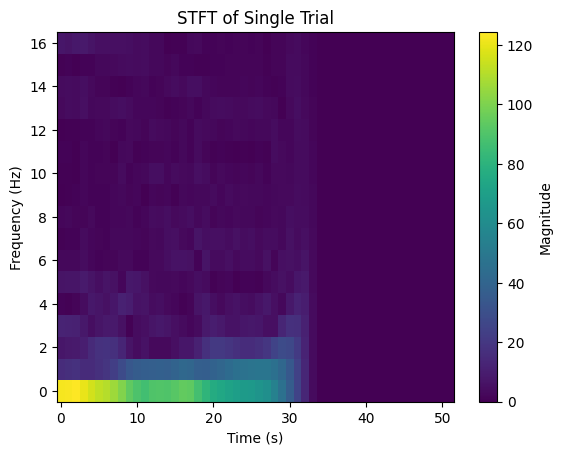

In [6]:
#visualize singal trial, y axis for frequency, x axis for time
plt.imshow(np.abs(stft_dataset[3, 5, :, :]), aspect='auto', origin='lower')
plt.colorbar(label='Magnitude')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.title('STFT of Single Trial')
plt.show()

In [7]:
# Filter relevant frequency bands (5-35 Hz)
print("Filtering frequency bands...")
f, stft_dataset = filter_relevant_frequencies_bands(stft_dataset, f, frequency_bands=[(5, 35)])
print(f"STFT dataset shape after filtering: {stft_dataset.shape}")

Filtering frequency bands...
STFT dataset shape after filtering: (64, 61415, 9, 52)


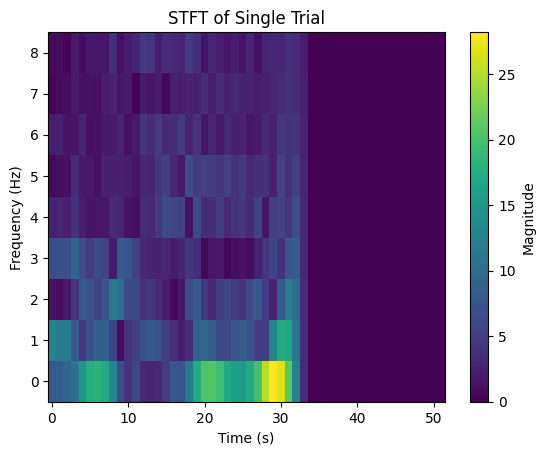

In [8]:
#visualize singal trial, y axis for frequency, x axis for time
plt.imshow(np.abs(stft_dataset[3, 5, :, :]), aspect='auto', origin='lower')
plt.colorbar(label='Magnitude')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.title('STFT of Single Trial')
plt.show()

In [44]:
no_tail_stft_dataset = np.copy(stft_dataset)
if cfg["response_locked"]:
    # Apply response-locked transformation
    print("Applying response-locked transformation...")
    no_tail_stft_dataset = response_locked_transform(stft_dataset)
    print(f"STFT dataset shape after response-locked transformation: {no_tail_stft_dataset.shape}")
else:
    print("Applying tail to NaN transformation...")
    no_tail_stft_dataset = stft_tail_to_nan(no_tail_stft_dataset, t, non_nan_counts[0])
    print(f"STFT dataset shape after tail processing: {no_tail_stft_dataset.shape}")

Applying response-locked transformation...
STFT dataset shape after response-locked transformation: (64, 61415, 9, 52)


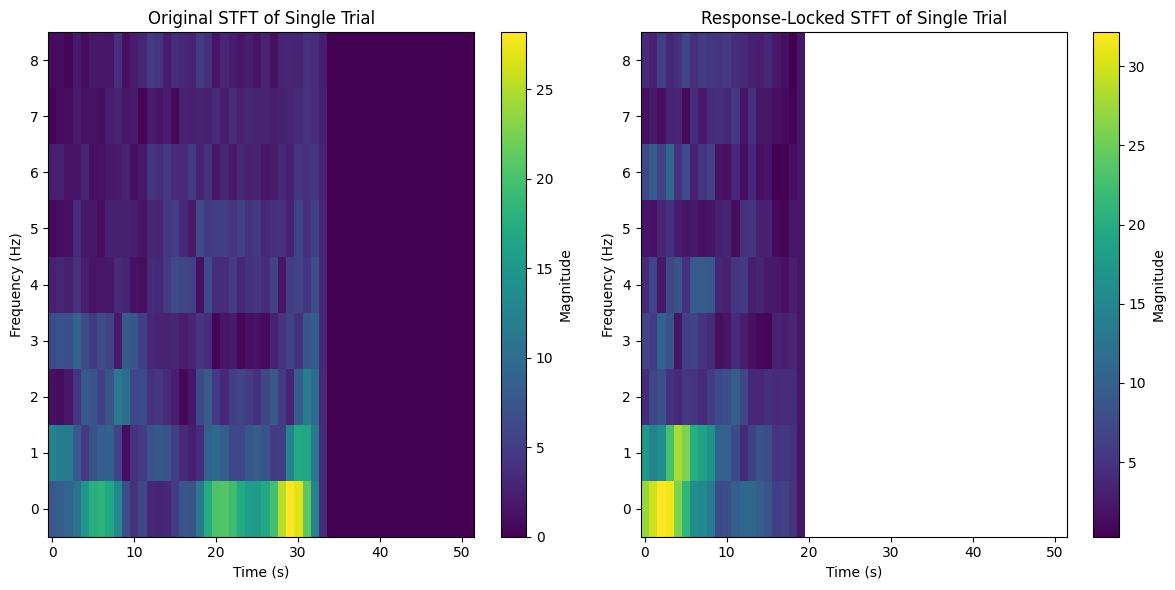

In [ ]:
# compare the two samples from the response locked dataset and the original dataset
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(np.abs(stft_dataset[3, 5, :, :]), aspect='auto', origin='lower')
plt.colorbar(label='Magnitude')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.title('Original STFT of Single Trial')
plt.subplot(1, 2, 2)
plt.imshow(np.abs(no_tail_stft_dataset[3, 5, :, :]), aspect='auto', origin='lower')
plt.colorbar(label='Magnitude')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.title('Response-Locked STFT of Single Trial')
plt.tight_layout()
plt.show()

In [47]:
# Create subset based on classification type
print(f"Creating subset for {cfg['classification_type']}...")
congruent_vs_incongruent = cfg["classification_type"] == "congruent_vs_incongruent"
free_choice_vs_instruction = cfg["classification_type"] == "free_choice_vs_instruction"

stft_data, labels, _, _, _, _ = create_subset_of_data_per_condition(
    no_tail_stft_dataset,
    true_labels,
    cues,
    primes,
    subjects_through_trials,
    non_nan_counts,
    electrodes_names=electrodes_names,
    min_range_value=cfg["min_range_value"],
    max_range_value=cfg["max_range_value"],
    simple=cfg["simple_data"],
    congruent_vs_incongruent=congruent_vs_incongruent,
    free_choice_vs_instruction=free_choice_vs_instruction,
    remove_subjects_groups=["MULTI_EMG"],
    without_short_trials=True,
    without_long_trials=True,
    specific_length_range=cfg["specific_length_range"],
    choose_electrodes=cfg["choose_electrodes"],
)
print(f"STFT data shape after subset creation: {stft_data.shape}")


Creating subset for congruent_vs_incongruent...
STFT data shape after subset creation: (31, 20910, 9, 52)


In [57]:
print(f"Unique labels: {np.unique(labels)}")
unique_labels = np.unique(labels)
if len(unique_labels) == 2:
    label_mapping = {unique_labels[0]: 0, unique_labels[1]: 1}
    labels = np.array([label_mapping[label] for label in labels])
    print(f"Remapped labels from {unique_labels} to [0, 1]")

transposed_stft_data = np.transpose(stft_data, (1, 0, 2, 3))
print(f"STFT data shape after transposing: {transposed_stft_data.shape}")

Unique labels: [0 1]
Remapped labels from [0 1] to [0, 1]
STFT data shape after transposing: (20910, 31, 9, 52)


In [58]:
# Split data along the trials axis
print("Splitting data...")

n_trials = stft_data.shape[1]
indices = np.arange(n_trials)

train_idx, test_idx, y_train, y_test = train_test_split(
    indices, labels, test_size=cfg["test_size"], random_state=cfg["random_seed"], stratify=labels
)

train_idx, val_idx, y_train, y_val = train_test_split(
    train_idx,
    y_train,
    test_size=cfg["val_size"] / (1 - cfg["test_size"]),
    random_state=cfg["random_seed"],
    stratify=y_train,
)

X_train = transposed_stft_data[train_idx, :, :, :]
X_val = transposed_stft_data[val_idx, :, :, :]
X_test = transposed_stft_data[test_idx, :, :, :]

print(f"Train set: {X_train.shape}")
print(f"Labels train set: {y_train.shape}")
print("-" * 50)
print(f"Validation set: {X_val.shape}")
print(f"Labels validation set: {y_val.shape}")
print("-" * 50)
print(f"Test set: {X_test.shape}")
print(f"Labels test set: {y_test.shape}")

Splitting data...
Train set: (14637, 31, 9, 52)
Labels train set: (14637,)
--------------------------------------------------
Validation set: (4182, 31, 9, 52)
Labels validation set: (4182,)
--------------------------------------------------
Test set: (2091, 31, 9, 52)
Labels test set: (2091,)


In [ ]:
"""Train the SpectrogramCNN model using HuggingFace Accelerator"""

accelerator = Accelerator()

# Convert data to tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
X_val = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.long)

# Create data loaders
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
train_loader = DataLoader(train_dataset, batch_size=cfg["batch_size"], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=cfg["batch_size"], shuffle=False)

# Initialize model
in_channels = X_train.shape[1]  # Number of electrodes
input_shape = (X_train.shape[2], X_train.shape[3])  # (freq, time)
model = SpectrogramCNN(in_channels=in_channels, num_classes=2, input_shape=input_shape)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=cfg["learning_rate"])
lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

# Prepare with accelerator
model, optimizer, train_loader, val_loader = accelerator.prepare(model, optimizer, train_loader, val_loader)

train_losses = []
val_losses = []
val_accuracies = []
num_epochs = cfg["num_epochs"]

for epoch in range(num_epochs):
    # Training
    model.train()
    train_loss = 0.0
    train_iter = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]", leave=False)
    for batch_X, batch_y in train_iter:
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        accelerator.backward(loss)
        optimizer.step()
        train_loss += loss.item()

    # Validation
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    val_iter = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]", leave=False)
    with torch.no_grad():
        for batch_X, batch_y in val_iter:
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += batch_y.size(0)
            correct += (predicted == batch_y).sum().item()

    train_loss /= len(train_loader)
    val_loss /= len(val_loader)
    val_accuracy = 100 * correct / total

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    # Log metrics to wandb
    wandb.log(
        {
            "epoch": epoch + 1,
            "train_loss": train_loss,
            "val_loss": val_loss,
            "val_accuracy": val_accuracy,
        }
    )

model = accelerator.unwrap_model(model)


In [62]:
"""Evaluate the trained model"""
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test = torch.tensor(y_test, dtype=torch.long)

model.eval()
with torch.no_grad():
    outputs = model(X_test)
    _, predicted = torch.max(outputs.data, 1)
    predicted = predicted.cpu().numpy()

accuracy = accuracy_score(y_test, predicted)
report = classification_report(y_test, predicted)
cm = confusion_matrix(y_test, predicted)

print(f"\nTest Accuracy: {accuracy:.4f}")
print("\nClassification Report:")
print(report)
print("\nConfusion Matrix:")
print(cm)


Test Accuracy: 0.5275

Classification Report:
              precision    recall  f1-score   support

           0       0.58      0.54      0.56      1156
           1       0.47      0.51      0.49       935

    accuracy                           0.53      2091
   macro avg       0.53      0.53      0.53      2091
weighted avg       0.53      0.53      0.53      2091


Confusion Matrix:
[[624 532]
 [456 479]]


/tmp/ipykernel_118241/1319731613.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
/tmp/ipykernel_118241/1319731613.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(y_test, dtype=torch.long)
